In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
from sklearn.model_selection import KFold

import xgboost as xgb

# Metric

In [17]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def maeOverFscore_xgboost(y_pred, dtrain):
    y_true = dtrain.get_label()
    return "maeOverFscore", maeOverFscore(y_true, y_pred)

def score(y_val, pred):
    f_value = fscore(y_val, pred)
    mae_value = maeOverFscore(y_val, pred)
    
    print(f"fscore : {f_value} \t maeOverFscore : {mae_value}")
    
    return (f_value, mae_value)

fscore_sklearn = make_scorer(fscore)
maeOverFscore_sklearn = make_scorer(maeOverFscore)

# data load

In [3]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [5]:
data = reshape(load_data('dl_train'))

# data seperate

In [7]:
X = data[:, :-1]
Y = data[:,  -1].reshape(X.shape[0], 1)
data = range(X.shape[0])
print(X.shape, Y.shape)

(1000000, 14) (1000000, 1)


# XGboost

In [34]:
params = {'objective': 'Regressor',  'eval_metric': 'mae', 
          'eta': 0.005, 'max_depth': 15, 'subsample': 0.6, 
          'colsample_bytree': 0.6, 'alpha':0.001, 
          'random_state': 7, 'silent': False}

In [46]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    train = xgb.DMatrix(X[train_idx, :], ) 
    val = xgb.DMatrix(X[val_idx, :], Y[val_idx, :])
    
    clf = xgb.XGBRegressor(max_depth=24, learning_rate=0.1, n_estimators=800, verbosity=1, silent=None, \
                           objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, \
                           min_child_weight=1, max_delta_step=0, subsample=1, \
                           colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, \
                           scale_pos_weight=1, base_score=0.5, random_state=0, seed=7, missing=None, importance_type='gain')
    
    clf.fit(X[train_idx, :], Y[train_idx, :], eval_set=[(X[val_idx, :], Y[val_idx, :])], \
            eval_metric=maeOverFscore_xgboost, sample_weight=None, \
            early_stopping_rounds=50, verbose=True, xgb_model=None, \
            sample_weight_eval_set=None, callbacks=None)
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

[17:44:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.35671	validation_0-maeOverFscore:16.1084
Multiple eval metrics have been passed: 'validation_0-maeOverFscore' will be used for early stopping.

Will train until validation_0-maeOverFscore hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.33117	validation_0-maeOverFscore:15.6068
[2]	validation_0-rmse:1.30184	validation_0-maeOverFscore:15.164
[3]	validation_0-rmse:1.28161	validation_0-maeOverFscore:14.9661
[4]	validation_0-rmse:1.26871	validation_0-maeOverFscore:14.8647
[5]	validation_0-rmse:1.25754	validation_0-maeOverFscore:14.7983
[6]	validation_0-rmse:1.25345	validation_0-maeOverFscore:14.8024
[7]	validation_0-rmse:1.24498	validation_0-maeOverFscore:14.8102
[8]	validation_0-rmse:1.24078	validation_0-maeOverFscore:14.8869
[9]	validation_0-rmse:1.23916	validation_0-maeOverFscore:14.9668
[10]	valid

KeyboardInterrupt: 

# Visualization

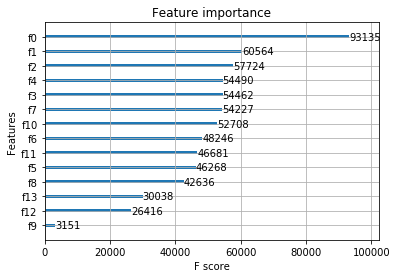

In [33]:
xgb.plot_importance(clf)

# All Train

In [ ]:
clf= xgb.XGBRegressor(max_depth=24, learning_rate=0.1, n_estimators=400, verbosity=1, silent=None, \
                  objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, \
                  min_child_weight=1, max_delta_step=0, subsample=1, \
                  colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, \
                  scale_pos_weight=1, base_score=0.5, random_state=0, seed=7, missing=None, importance_type='gain')

In [ ]:
clf.fit(X, Y, \
        sample_weight=None, xgb_model=None, \
        sample_weight_eval_set=None, \
        verbose=True, callbacks=None)

# Submit

In [ ]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [ ]:
submit(clf, 'xgboost')